In [1]:
import os
from enum import Enum
import numpy as np
from PIL import Image
import cv2
import torch
import torch.nn as nn
from torchvision import transforms, models
import matplotlib.pyplot as plt

In [2]:
class EnumArchitecture(Enum):
    EFFICIENTNET = "efficientnet"
    RESNET = "resnet"

In [3]:
ANS = 0
TRUE={
    "0": "0Aptenodytes/",
    "1": "1Pygoscelis/",
    "2": "2Spheniscus/",
    "3": "3Eudyptes/",
    "4": "4Megadyptes/",
    "5": "5Eudyptula/",
    "6": "6Other/",
}
NUMBER = "penguin"
ARCHITECTURE = EnumArchitecture.EFFICIENTNET.value
MODEL = f"../train/model/{ARCHITECTURE}-penguin-7cls.pt"
out_features = len(TRUE)
ans = "train" # col # misd

for k, i in TRUE.items():
    os.makedirs(f"heatmap/{NUMBER}/{i}", exist_ok=True)

In [4]:
device = torch.device("cuda")
# model initialization
model = None

# efficientnet
if ARCHITECTURE == EnumArchitecture.EFFICIENTNET.value:
    model = models.efficientnet_v2_s().to(device)
    model.classifier = nn.Linear(in_features=1280, out_features=out_features).to(device)
    model.load_state_dict(torch.load(MODEL))
    model.to(device)
    model.eval()
# resnet
elif ARCHITECTURE == EnumArchitecture.RESNET.value:
    model = models.resnet101().to(device)
    model.fc = nn.Linear(in_features=512, out_features=out_features).to(device)
    model.load_state_dict(torch.load(MODEL))
    model.to(device)
    model.eval()

In [5]:
fig = None
def grad_cam(net, img_fpath, ans):
    net.to(device)
    net.eval()
    ROW = 10
    COLUMNS = 5
    global j
    if j > ROW * COLUMNS:
        return
    global k
    k += 1
    
    img = Image.open(img_fpath).convert("RGB")
    if ARCHITECTURE == EnumArchitecture.EFFICIENTNET.value:
        cnn_transforms = transforms.Compose([
            transforms.Resize((384,384)),
            transforms.ToTensor()
        ])
    elif ARCHITECTURE == EnumArchitecture.RESNET.value:
        cnn_transforms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor()
        ])
    img = cnn_transforms(img).to(device).float()
    img = img.unsqueeze(0)
    
    if ARCHITECTURE == EnumArchitecture.EFFICIENTNET.value:
        modules = list(net.children())[:-2]
        last_conv_layer = nn.Sequential(*modules)
        x = last_conv_layer(img)
    elif ARCHITECTURE == EnumArchitecture.RESNET.value:
        x = net.conv1(img)
        x = net.bn1(x)
        x = net.relu(x)
        x = net.maxpool(x)
        x = net.layer1(x)
        x = net.layer2(x)
        x = net.layer3(x)
        x = net.layer4(x)
    features = x
    
    
    def __extract(grad):
        global feature_grad
        feature_grad = grad
    features.register_hook(__extract)

    x = net.avgpool(x)
    x = x.view(x.size(0), -1)
    if ARCHITECTURE == EnumArchitecture.EFFICIENTNET.value:
        output = net.classifier(x)
    elif ARCHITECTURE == EnumArchitecture.RESNET.value:
        output = net.fc(x)
    pred = torch.argmax(output).item()
    
    global results
    results[pred] = results[pred] + 1
    
    if ans == "train" and pred != ANS:
        return
    elif ans == "col" and pred != ANS:
        return
    elif ans == "misd" and pred == ANS:
        return
    
    output[:,pred].backward()
    pooled_grad = torch.mean(feature_grad, dim=[0,2,3])
    features = features.detach().to(device)
    
    for i in range(features.shape[1]):
        features[:,i,:,:] *= pooled_grad[i]
    
    heatmap = torch.mean(features, dim=1).squeeze()
    heatmap = heatmap.cpu().numpy().copy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = torch.tensor(heatmap).to("cuda") / torch.max(torch.tensor(heatmap).to("cuda"))
    heatmap = heatmap.cpu().numpy().copy()
    
    img = cv2.imread(img_fpath)
    heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + img
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))
    superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    j += 1
    if j > ROW * COLUMNS:
        return
    
    ax = fig.add_subplot(ROW, COLUMNS, j)
    ax.axis("off")
    ax.set_title(f"PRED: {TRUE[str(pred)][:2]} TRUE: {TRUE[str(ANS)][:2]}\n{os.path.basename(img_fpath)[-20:]}")
    plt.subplots_adjust(hspace=0.4)
        
    if ARCHITECTURE == EnumArchitecture.EFFICIENTNET.value:
        ax.imshow(cv2.resize(superimposed_img, (384,384)))
    elif ARCHITECTURE == EnumArchitecture.RESNET.value:
        ax.imshow(cv2.resize(superimposed_img, (224,224)))

In [6]:
def grad_cam_wrapper(ans):
    if ans == "train":
        IMG_DIR = f"../train/data/penguins/train/{TRUE[str(ANS)]}/"
    else:
        IMG_DIR = f"../train/data/penguins/test/{TRUE[str(ANS)]}/"
    
    files = os.listdir(IMG_DIR)
    image_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    
    for file in files:
        file_extension = os.path.splitext(file)[1]
        # 画像ファイルかチェック
        if file_extension.lower() not in image_extensions:
            continue
        grad_cam(model, IMG_DIR + file, ans)
    

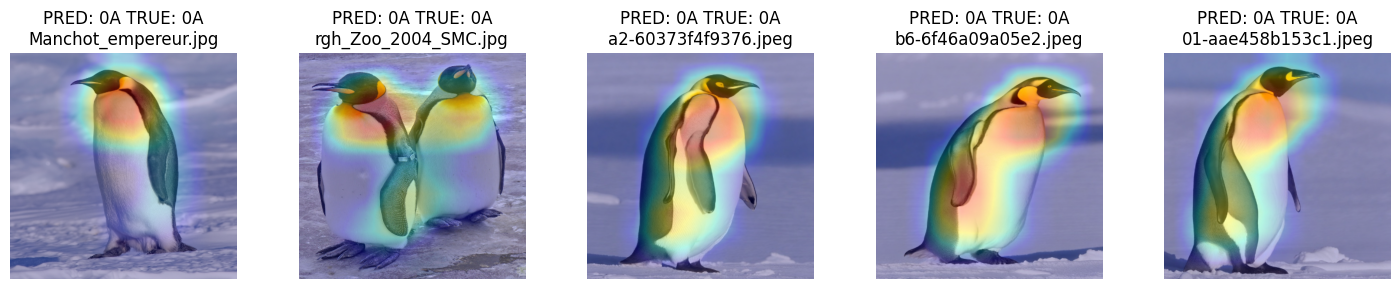

In [8]:
j, k = 0, 0
results = [0] * len(TRUE)
fig = plt.figure(figsize=(18,40))

grad_cam_wrapper(ans)
plt.savefig(f"./heatmap/{NUMBER}/{TRUE[str(ANS)]}/{TRUE[str(ANS)][:2]}_heatmap_{ans}.png")